In [1]:
import numpy as np
import pandas as pd
import os

from pathlib import Path

In [2]:
FRAUD_NN_SAVE_BASE_PATH = "causal_diconstruct_fraudNN_baselines"
FRAUD_NN_ABS_SAVE_BASE_PATH = os.path.abspath(FRAUD_NN_SAVE_BASE_PATH)
FRAUD_NN_MODEL_RESULTS_PATH = os.path.join(
    FRAUD_NN_SAVE_BASE_PATH, "baseline_results.csv"
)

FRAUD_LGBM_SAVE_BASE_PATH = "causal_concept_distil_baselines"
FRAUD_LGBM_ABS_SAVE_BASE_PATH = os.path.abspath(FRAUD_LGBM_SAVE_BASE_PATH)
FRAUD_LGBM_MODEL_RESULTS_PATH = os.path.join(
    FRAUD_LGBM_SAVE_BASE_PATH, "baseline_results.csv"
)

CUB_SAVE_BASE_PATH = "causal_diconstruct_CUB_baselines"
CUB_ABS_SAVE_BASE_PATH = os.path.abspath(CUB_SAVE_BASE_PATH)
CUB_MODEL_RESULTS_PATH = os.path.join(CUB_SAVE_BASE_PATH, "baseline_results.csv")

SAVE_BASE_PATH = "causal_diconstruct_experiments"
ABS_SAVE_BASE_PATH = os.path.abspath(SAVE_BASE_PATH)
MODEL_RESULTS_PATH = os.path.join(SAVE_BASE_PATH, "all_results.csv")

CBM_SAVE_BASE_PATH = "concept_bottleneck_experiments"
CBM_ABS_SAVE_BASE_PATH = os.path.abspath(CBM_SAVE_BASE_PATH)
CBM_RESULTS_PATH = os.path.join(CBM_ABS_SAVE_BASE_PATH, "all_results.csv")


N_TRIALS = int(1e3)
CONFIGS_PER_TRIAL = 20 # Use 20% of generated configs.
SEED = 7

DEFINITION = 0.01

ALGOS = "all"

DISTILLATION_METRIC_SELECTION = "validation_abs_fidelity"
EXPLAINABILITY_METRIC_SELECTION = "validation_concept_acc"
DISTILLATION_METRIC = "test_abs_fidelity"
EXPLAINABILITY_METRIC = "test_concept_acc"

In [3]:
results = pd.concat(
    [
        pd.read_csv(FRAUD_NN_MODEL_RESULTS_PATH),
        pd.read_csv(FRAUD_LGBM_MODEL_RESULTS_PATH),
        pd.read_csv(CUB_MODEL_RESULTS_PATH),
        pd.read_csv(MODEL_RESULTS_PATH),
        pd.read_csv(CBM_RESULTS_PATH),
    ]
)

results["algorithm"] = results["model_category"]
results["run"] = results.groupby("algorithm").cumcount() + 1

results["algorithm"].unique()

array(['fraudNN_distillation_baseline', 'explainability_baseline',
       'distillation_baseline', 'independent_components_baseline',
       'distillation_CUB_baseline', 'explainability_CUB_baseline',
       'independent_components_CUB_baseline',
       'exogenous_local_pc_fraud_lgbm',
       'trainable_local_icalingam_fraud_nn',
       'exogenous_local_icalingam_fraud_nn',
       'exogenous_global_icalingam_fraud_nn',
       'trainable_local_icalingam_fraud_lgbm',
       'trainable_global_icalingam_fraud_nn',
       'exogenous_local_icalingam_fraud_lgbm',
       'exogenous_global_icalingam_fraud_lgbm',
       'trainable_global_icalingam_fraud_lgbm',
       'trainable_global_notears_fraud_lgbm',
       'exogenous_global_notears_fraud_lgbm',
       'exogenous_local_notears_fraud_lgbm',
       'trainable_local_notears_fraud_lgbm',
       'trainable_global_notears_fraud_nn',
       'exogenous_global_notears_fraud_nn',
       'trainable_local_notears_fraud_nn',
       'exogenous_local_note

In [58]:
all_algos_cub = {
    "trainable_cbm_cub_nn",
    "exogenous_cbm_cub_nn",
    "exogenous_local_pc_cub_nn",
    "trainable_local_icalingam_cub_nn",
    "trainable_global_notears_cub_nn",
    "exogenous_global_icalingam_cub_nn",
}

all_algos_fraud_nn = {
    "trainable_cbm_fraud_nn",
    "exogenous_cbm_fraud_nn",
    "exogenous_local_pc_fraud_nn",
    "trainable_local_pc_fraud_nn",
    "trainable_global_notears_fraud_nn",
    "exogenous_global_icalingam_fraud_nn",
}

all_algos_fraud_lgbm = {
    "trainable_cbm_fraud_lgbm",
    "exogenous_cbm_fraud_lgbm",
    "exogenous_local_pc_fraud_lgbm",
    "trainable_local_trivial_fraud_lgbm",
    "trainable_global_notears_fraud_lgbm",
    "exogenous_global_pc_fraud_lgbm",
}

selected_algos = ALGOS.intersection(all_algos_fraud_lgbm) if isinstance(ALGOS, set) else all_algos_fraud_lgbm

In [60]:
np.random.seed(SEED)

results_dict_fraud_lgbm = {}

alphas = np.linspace(0.0, 1.0, num=int(1 / DEFINITION) + 1)

for algo in selected_algos:
    print(algo)
    results_dict_fraud_lgbm[algo] = {}
    trained_models = results[results["algorithm"] == algo]
    for alpha in alphas:
        print(alpha)
        sampling_seeds = np.random.choice(N_TRIALS, N_TRIALS, replace=False)
        models_numbers = trained_models["run"].unique()
        trained_models["selection_metric"] = (
            alpha * trained_models[DISTILLATION_METRIC_SELECTION]
            + (1 - alpha) * trained_models[EXPLAINABILITY_METRIC_SELECTION]
        )
        distillation = []
        explainability = []
        alpha_weighted = []
        for seed in sampling_seeds:
            np.random.seed(seed)
            sampled_models_numbers = np.random.choice(
                models_numbers, size=CONFIGS_PER_TRIAL, replace=True
            )
            sampled_models = trained_models[
                trained_models["run"].isin(sampled_models_numbers)
            ]
            best_model = sampled_models.sort_values(
                "selection_metric", ascending=False
            ).iloc[0]
            distillation.append(best_model[DISTILLATION_METRIC])
            explainability.append(best_model[EXPLAINABILITY_METRIC])
            alpha_weighted.append(
                alpha * best_model[DISTILLATION_METRIC]
                + (1 - alpha) * best_model[EXPLAINABILITY_METRIC]
            )
        results_dict_fraud_lgbm[algo][alpha] = {
            "Distillaion": distillation,
            "Explainability": explainability,
            "Alpha Metric": alpha_weighted,
        }

exogenous_global_pc_fraud_lgbm
0.0


/mnt/home/ricardo.moreira/concept-based-explanations/concept_weasul_condapack/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0
trainable_local_trivial_fraud_lgbm
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57000

In [4]:
import pickle
with open("alpha_results_fraud_lgbm.pkl", "rb") as f:
    results_dict_fraud_lgbm = pickle.load(f)

In [24]:
distillation_mean = {}
distillation_ub = {}
distillation_lb = {}


explainability_mean = {}
explainability_ub = {}
explainability_lb = {}


ci = 0.01

for algo in results_dict.keys():
    distillation_mean[algo] = []
    distillation_ub[algo] = []
    distillation_lb[algo] = []
    explainability_mean[algo] = []
    explainability_ub[algo] = []
    explainability_lb[algo] = []
    for alpha in results_dict[algo].keys():
        for metric in ["Distillaion", "Explainability"]:
            trials = np.array(results_dict[algo][alpha][metric])
            mean = np.mean(trials)
            ub = np.quantile(trials, 1-ci)
            lb = np.quantile(trials, ci)
            if metric == "Performance":
                distillation_mean[algo].append(mean)
                distillation_ub[algo].append(ub)
                distillation_lb[algo].append(lb)
            else:
                explainability_mean[algo].append(mean)
                explainability_ub[algo].append(ub)
                explainability_lb[algo].append(lb)

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

x = list(results_dict_fraud_lgbm['trainable_cbm_fraud_lgbm'].keys())

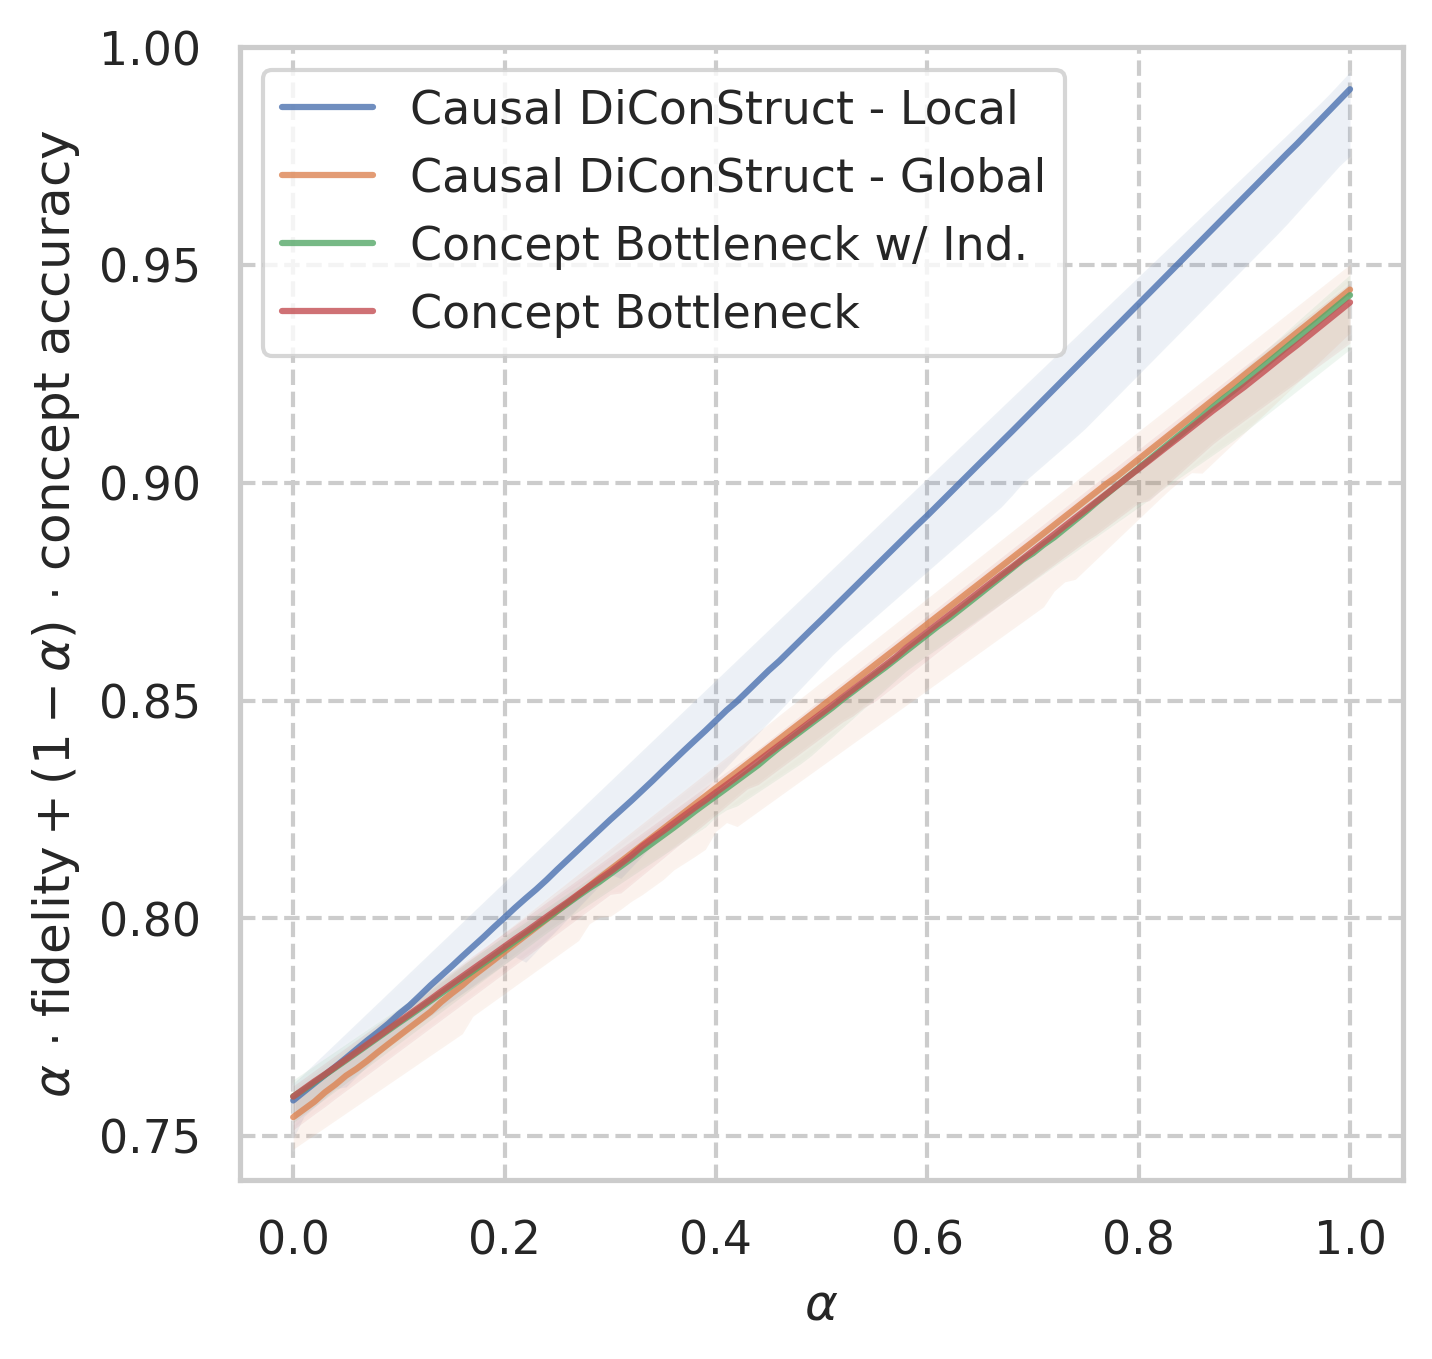

In [97]:
algos_names = {
    "trainable_cbm_cub_nn": "Concept Bottleneck",
    "exogenous_cbm_cub_nn": "Concept Bottleneck w/ Ind.",
    "exogenous_local_pc_cub_nn": "Causal DiConStruct - Local",
    "trainable_local_icalingam_cub_nn": "Causal DiConStruct - Local",
    "trainable_global_notears_cub_nn": "Causal DiConStruct - Global",
    "exogenous_global_icalingam_cub_nn": "Causal DiConStruct - Global",
}

order = [
    "exogenous_local_pc_cub_nn",
    "trainable_global_notears_cub_nn",
    "exogenous_cbm_cub_nn",
    "trainable_cbm_cub_nn",
    #"trainable_local_icalingam_cub_nn",
    #"exogenous_global_icalingam_cub_nn",
]

ci = 0.02

alpha_metric_mean = {}
ci_ub = {}
ci_lb = {}
plt.figure(dpi=300, figsize=(5, 5))
for algo in results_dict.keys():
    alpha_metric_mean[algo] = []
    ci_ub[algo] = []
    ci_lb[algo] = []
    for alpha in results_dict[algo].keys():
        alpha_metric_mean[algo].append(np.mean(results_dict[algo][alpha]["Alpha Metric"]))
        ci_ub[algo].append(np.quantile(results_dict[algo][alpha]["Alpha Metric"], 1-ci))
        ci_lb[algo].append(np.quantile(results_dict[algo][alpha]["Alpha Metric"], ci))

for algo in order:
    plt.plot(x, alpha_metric_mean[algo], label=algos_names[algo], alpha=0.8)
    plt.fill_between(x, ci_lb[algo], ci_ub[algo], alpha=0.1)
plt.ylim([0.74, 1.0])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\alpha\ \dot \ \mathrm{fidelity} + (1 - \alpha)\ \dot \ \mathrm{concept} \ \mathrm{accuracy}$")
plt.legend();

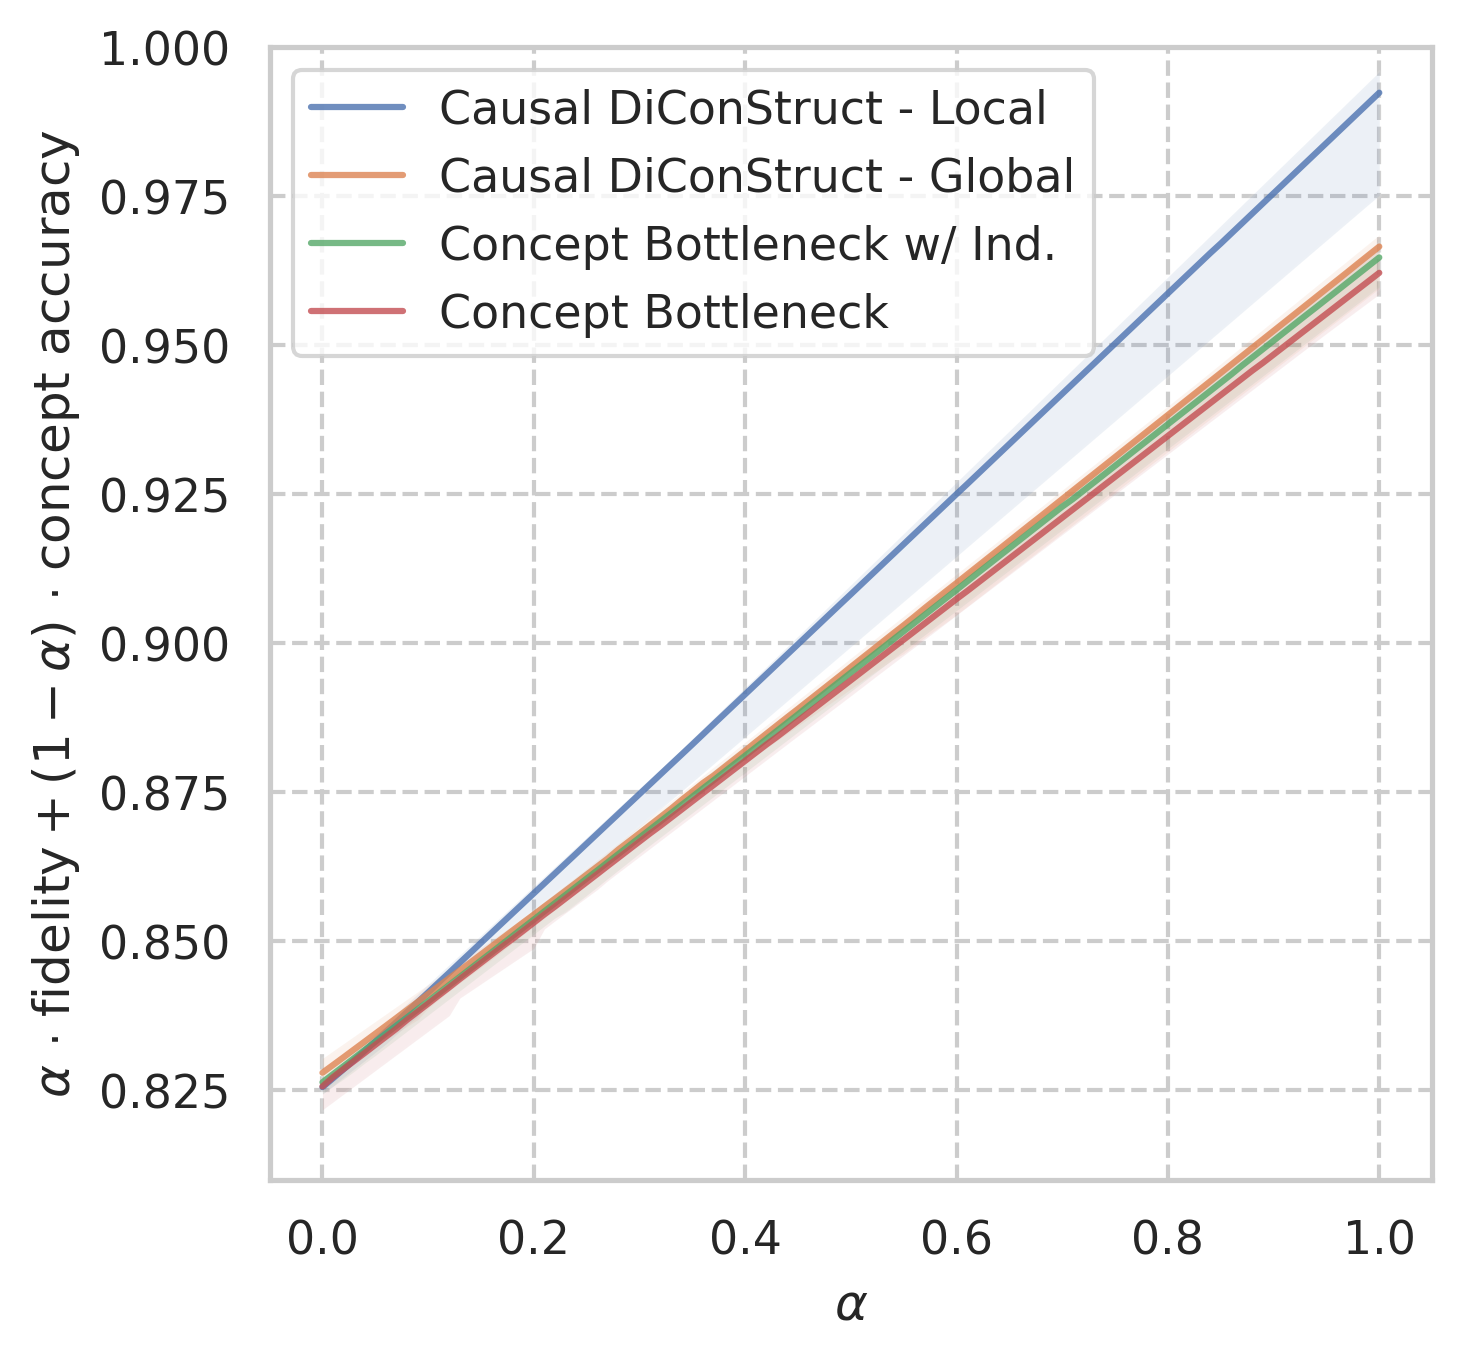

In [96]:
algos_names = {
    "trainable_cbm_fraud_nn": "Concept Bottleneck",
    "exogenous_cbm_fraud_nn": "Concept Bottleneck w/ Ind.",
    "exogenous_local_pc_fraud_nn": "Causal DiConStruct - Local",
    "trainable_local_pc_fraud_nn": "Causal DiConStruct - Local",
    "trainable_global_notears_fraud_nn": "Causal DiConStruct - Global",
    "exogenous_global_icalingam_fraud_nn": "Causal DiConStruct - Global",
}

order = [
    "exogenous_local_pc_fraud_nn",
    "trainable_global_notears_fraud_nn",
    "exogenous_cbm_fraud_nn",
    "trainable_cbm_fraud_nn",
    #"trainable_local_pc_fraud_nn",
    #"exogenous_global_icalingam_fraud_nn",
]

ci = 0.02

alpha_metric_mean = {}
ci_ub = {}
ci_lb = {}
plt.figure(dpi=300, figsize=(5, 5))
for algo in results_dict_fraud_nn.keys():
    alpha_metric_mean[algo] = []
    ci_ub[algo] = []
    ci_lb[algo] = []
    for alpha in results_dict_fraud_nn[algo].keys():
        alpha_metric_mean[algo].append(
            np.mean(results_dict_fraud_nn[algo][alpha]["Alpha Metric"])
        )
        ci_ub[algo].append(
            np.quantile(results_dict_fraud_nn[algo][alpha]["Alpha Metric"], 1 - ci)
        )
        ci_lb[algo].append(
            np.quantile(results_dict_fraud_nn[algo][alpha]["Alpha Metric"], ci)
        )

for algo in order:
    plt.plot(x, alpha_metric_mean[algo], label=algos_names[algo], alpha=0.8)
    plt.fill_between(x, ci_lb[algo], ci_ub[algo], alpha=0.1)
plt.ylim([0.81, 1.0])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\alpha\ \dot \ \mathrm{fidelity} + (1 - \alpha)\ \dot \ \mathrm{concept} \ \mathrm{accuracy}$")
plt.legend()

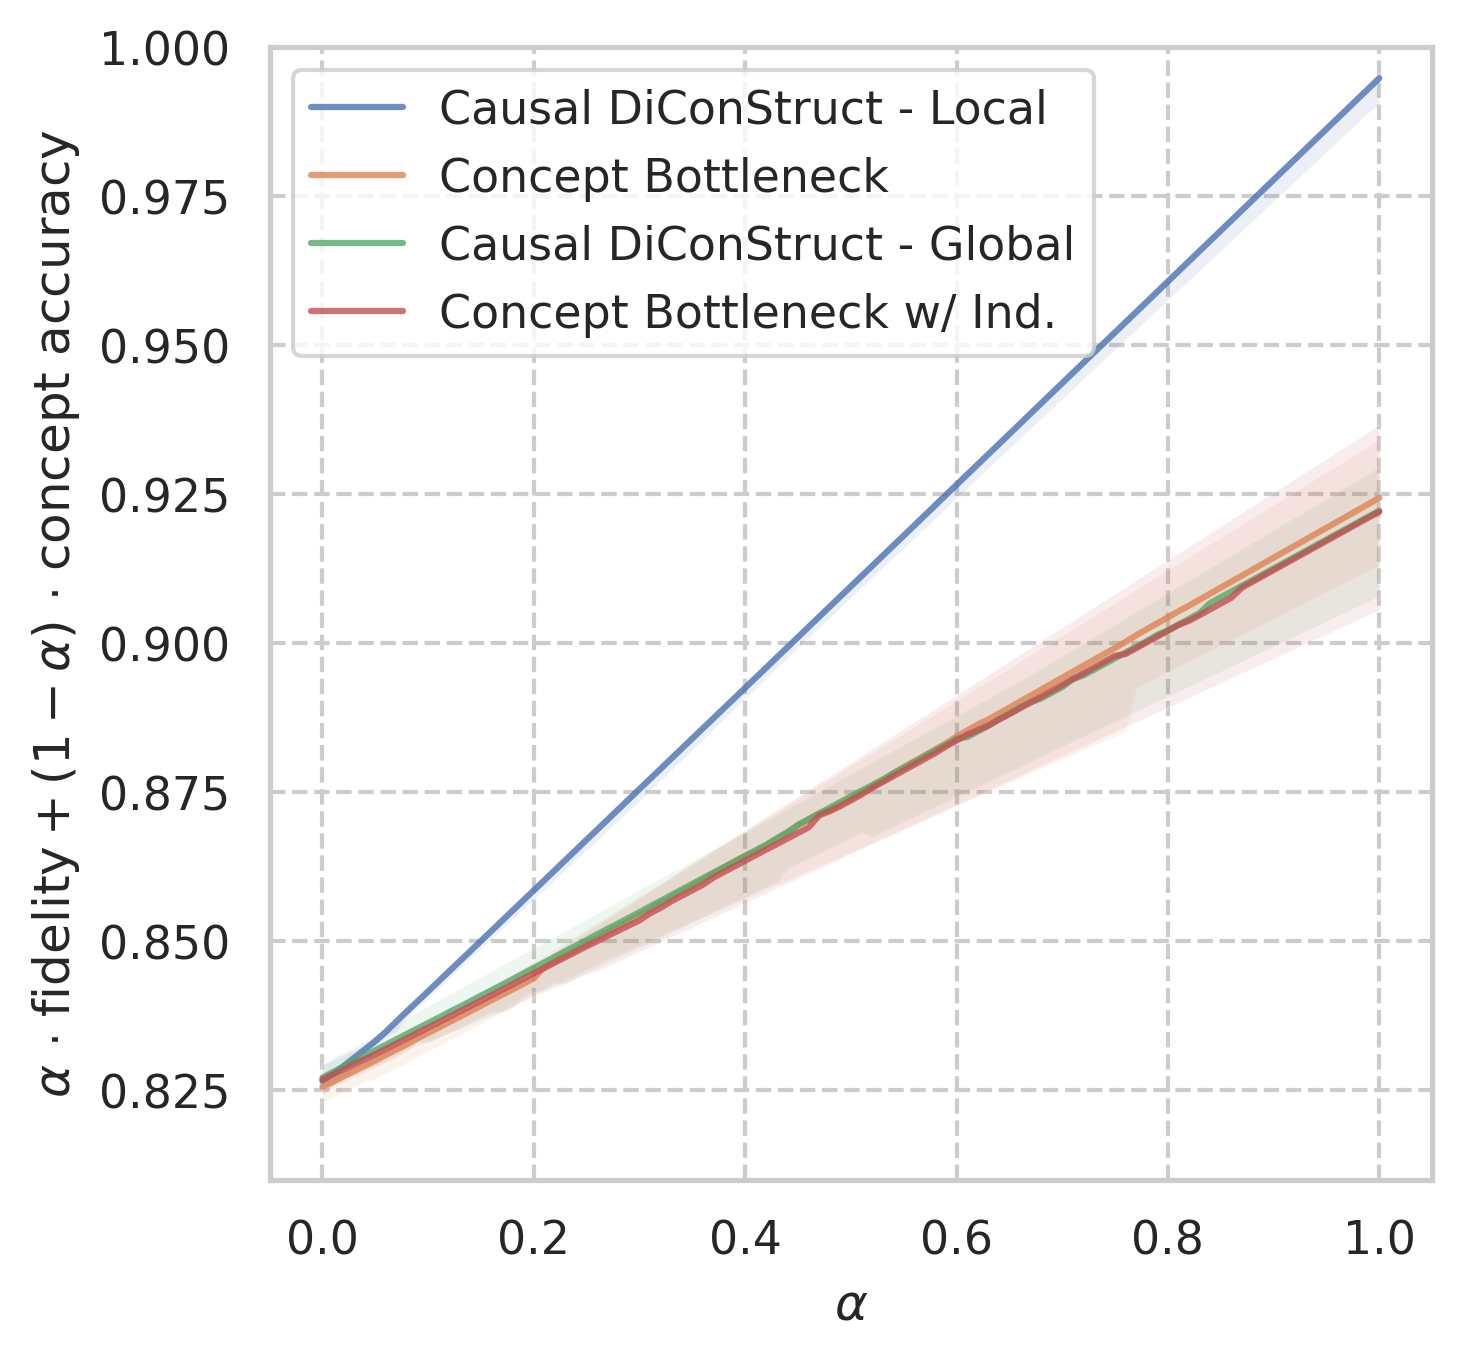

In [22]:
algos_names = {
    "trainable_cbm_fraud_lgbm": "Concept Bottleneck",
    "exogenous_cbm_fraud_lgbm": "Concept Bottleneck w/ Ind.",
    "exogenous_local_pc_fraud_lgbm": "Causal DiConStruct - Local",
    "trainable_local_trivial_fraud_lgbm": "Causal DiConStruct - Local",
    "trainable_global_notears_fraud_lgbm": "Causal DiConStruct - Global",
    "exogenous_global_pc_fraud_lgbm": "Causal DiConStruct - Global",
}


order = [
    "exogenous_local_pc_fraud_lgbm",
    "trainable_cbm_fraud_lgbm",
    "trainable_global_notears_fraud_lgbm",
    "exogenous_cbm_fraud_lgbm",
    # "trainable_local_trivial_fraud_lgbm",
    # "exogenous_global_pc_fraud_lgbm",
]
ci = 0.02

alpha_metric_mean = {}
ci_ub = {}
ci_lb = {}
plt.figure(dpi=300, figsize=(5, 5))
for algo in results_dict_fraud_lgbm.keys():
    alpha_metric_mean[algo] = []
    ci_ub[algo] = []
    ci_lb[algo] = []
    for alpha in results_dict_fraud_lgbm[algo].keys():
        alpha_metric_mean[algo].append(
            np.mean(results_dict_fraud_lgbm[algo][alpha]["Alpha Metric"])
        )
        ci_ub[algo].append(
            np.quantile(results_dict_fraud_lgbm[algo][alpha]["Alpha Metric"], 1 - ci)
        )
        ci_lb[algo].append(
            np.quantile(results_dict_fraud_lgbm[algo][alpha]["Alpha Metric"], ci)
        )

for algo in order:
    plt.plot(x, alpha_metric_mean[algo], label=algos_names[algo], alpha=0.8)
    plt.fill_between(x, ci_lb[algo], ci_ub[algo], alpha=0.1)
plt.ylim([0.81, 1.0])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\alpha\ \dot \ \mathrm{fidelity} + (1 - \alpha)\ \dot \ \mathrm{concept} \ \mathrm{accuracy}$")
plt.legend()